In [109]:
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
import folium
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


df1 = pd.read_csv("final_tayara_data.csv")
df2 = pd.read_csv("mubawab_grand_tunis.csv")
df3 = pd.read_csv("tecnocasa_final.csv")

# Renommage
df2 = df2.rename(columns={"longitude":"lon", "latitude":"lat"})

# Alignement
df2 = df2[df1.columns]
df3 = df3[df1.columns]  


# Concaténation
merged_df = pd.concat([df1, df2, df3], axis=0, ignore_index=True)

#merged_df = df3
# AFFICHAGE DU NOMBRE DE LIGNES
print("="*50)
print("NOMBRE DE LIGNES PAR SOURCE")
print("="*50)
print(f"Tayara (df1)    : {len(df1):>8,} lignes")
print(f"Mubawab (df2)   : {len(df2):>8,} lignes")
print(f"Tecnocasa (df3) : {len(df3):>8,} lignes")
print("-"*50)
print(f"TOTAL           : {len(merged_df):>8,} lignes")
print("="*50)

# Vérification rapide
print(f"\n Fusion réussie: {len(merged_df) == len(df1) + len(df2) + len(df3)}")


print(merged_df.info())


NOMBRE DE LIGNES PAR SOURCE
Tayara (df1)    :      678 lignes
Mubawab (df2)   :    2,840 lignes
Tecnocasa (df3) :      192 lignes
--------------------------------------------------
TOTAL           :    3,710 lignes

 Fusion réussie: True
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3710 entries, 0 to 3709
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   prix                        3710 non-null   float64
 1   categorie                   3710 non-null   int64  
 2   surface                     3710 non-null   float64
 3   nombre_des_chambres         3710 non-null   float64
 4   nombre_des_salles_de_bains  3710 non-null   float64
 5   haut_standing               3710 non-null   int64  
 6   terrasse                    3710 non-null   int64  
 7   balcon                      3710 non-null   int64  
 8   etage                       3710 non-null   float64
 9   parking                

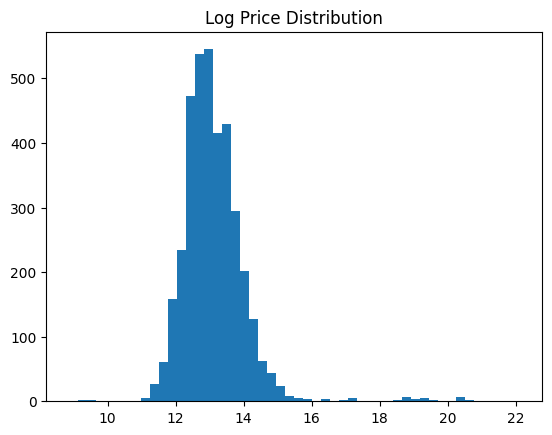

In [110]:
import numpy as np
plt.hist(np.log1p(merged_df["prix"]), bins=50)
plt.title("Log Price Distribution")
plt.show()


In [111]:
print("Duplicates:", merged_df.duplicated().sum())
merged_df = merged_df.drop_duplicates()
print(merged_df.isna().sum())


Duplicates: 27
prix                          0
categorie                     0
surface                       0
nombre_des_chambres           0
nombre_des_salles_de_bains    0
haut_standing                 0
terrasse                      0
balcon                        0
etage                         0
parking                       0
ascenseur                     0
jardin                        0
vue_panoramique               0
climatiseur                   0
chauffage_central             0
piscine                       0
lat                           0
lon                           0
dtype: int64


In [112]:
print("Surface = 0 count:", (merged_df["surface"] == 0).sum())
merged_df = merged_df[merged_df["surface"] > 0]
merged_df["price_per_m2"] = merged_df["prix"] / merged_df["surface"]



Surface = 0 count: 49


In [113]:
# Liste des colonnes à filtrer
cols_to_filter = [
    #"surface",
 
    #"nombre_des_chambres",
    #"nombre_des_salles_de_bains",
    #"lat",
    #"lon",
    "price_per_m2"  # si applicable
]

# Créer un dictionnaire pour stocker les percentiles
percentiles = {}

# Calculer les 5ème et 95ème percentiles pour chaque colonne
for col in cols_to_filter:
    q_low = merged_df[col].quantile(0.05)
    q_high = merged_df[col].quantile(0.95)
    percentiles[col] = (q_low, q_high)
    print(f"{col}: 5th percentile = {q_low}, 95th percentile = {q_high}")

# Appliquer le filtrage sur toutes les colonnes
filtered_df = merged_df.copy()
for col in cols_to_filter:
    q_low, q_high = percentiles[col]
    filtered_df = filtered_df[(filtered_df[col] >= q_low) & (filtered_df[col] <= q_high)]

# Résultat final
print(f"Lignes avant filtrage : {len(merged_df)}")
print(f"Lignes après filtrage : {len(filtered_df)}")
print(f"Lignes éliminées : {len(merged_df) - len(filtered_df)} ({(len(merged_df) - len(filtered_df))/len(merged_df)*100:.2f}%)")

# Mettre à jour le DataFrame si vous voulez l’utiliser ensuite
merged_df = filtered_df.copy()



price_per_m2: 5th percentile = 1225.524193548387, 95th percentile = 6370.979020979019
Lignes avant filtrage : 3634
Lignes après filtrage : 3270
Lignes éliminées : 364 (10.02%)


In [114]:
print("Unique values nb de chambres:")
print(sorted(merged_df["nombre_des_chambres"].unique()))
print("Unique values nb de salle de bain:")
print(sorted(merged_df["nombre_des_salles_de_bains"].unique()))


Unique values nb de chambres:
[np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(13.0), np.float64(14.0), np.float64(15.0), np.float64(16.0), np.float64(19.0), np.float64(20.0), np.float64(48.0)]
Unique values nb de salle de bain:
[np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0), np.float64(24.0), np.float64(1450000.0)]


In [115]:
#Remove extreme unrealistic values
merged_df = merged_df[
    merged_df["nombre_des_chambres"] <= 15
]
merged_df = merged_df[
    merged_df["nombre_des_salles_de_bains"] <= 10
]

In [116]:
print("Total number of rows:", len(merged_df))


Total number of rows: 3261


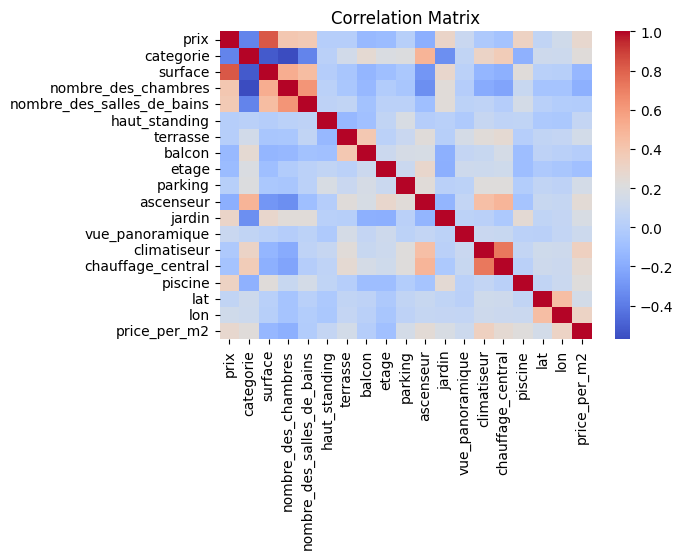

In [117]:

plt.figure(figsize=(6,4))
sns.heatmap(merged_df.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()



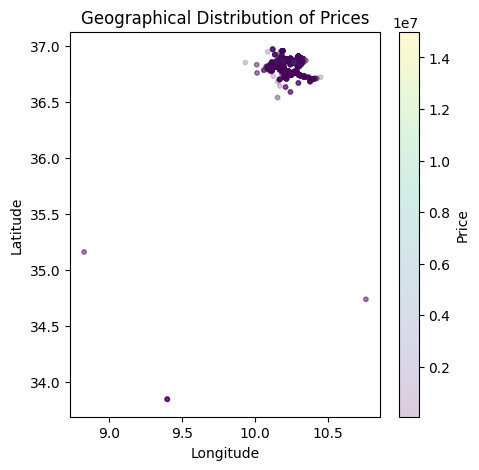

In [118]:
plt.figure(figsize=(5,5))
plt.scatter(
    merged_df["lon"],
    merged_df["lat"],
    c=merged_df["prix"],
    cmap="viridis",
    alpha=0.2,      # more transparency
    s=10            # smaller points
)

plt.colorbar(label="Price")
plt.title("Geographical Distribution of Prices")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


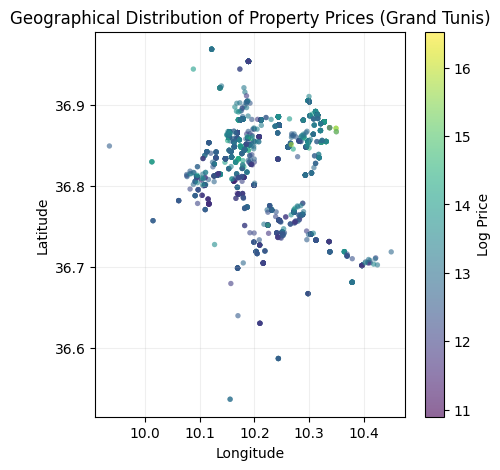

In [119]:
merged_df = merged_df[
    (merged_df["lat"] > 36.5) &
    (merged_df["lat"] < 37.5) &
    (merged_df["lon"] > 9.75) &
    (merged_df["lon"] < 10.5)
]
plt.figure(figsize=(5,5))
plt.scatter(
    merged_df["lon"],
    merged_df["lat"],
    c=np.log1p(merged_df["prix"]),
    cmap="viridis",
    alpha=0.6,
    s=15,
    edgecolors='none'
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographical Distribution of Property Prices (Grand Tunis)")
plt.grid(alpha=0.2)
plt.colorbar(label="Log Price")
plt.show()



In [120]:

coords = merged_df[["lat", "lon"]]
kmeans = KMeans(n_clusters=6, random_state=42)

eda_df = merged_df.copy()

eda_df["geo_cluster"] = kmeans.fit_predict(coords)

centers = kmeans.cluster_centers_
print(centers)


cluster_price = eda_df.groupby("geo_cluster")["prix"].mean().sort_values()
print(cluster_price.apply(lambda x: f"{x:,.0f}"))




[[36.87049334 10.31133833]
 [36.81291573 10.13561574]
 [36.70766957 10.37569404]
 [36.86305117 10.25286991]
 [36.87338314 10.18131537]
 [36.73988537 10.24925058]]
geo_cluster
5    391,216
2    484,915
3    487,426
1    493,194
4    552,581
0    880,484
Name: prix, dtype: object


In [121]:
cluster_names = {
    3: "Budget Housing",
    5: "Lower-Middle Segment",
    2: "Middle Segment",
    0: "Upper-Middle Segment",
    1: "Premium Segment",
    4: "Luxury Segment"
}


eda_df["cluster_name"] = eda_df["geo_cluster"].map(cluster_names)


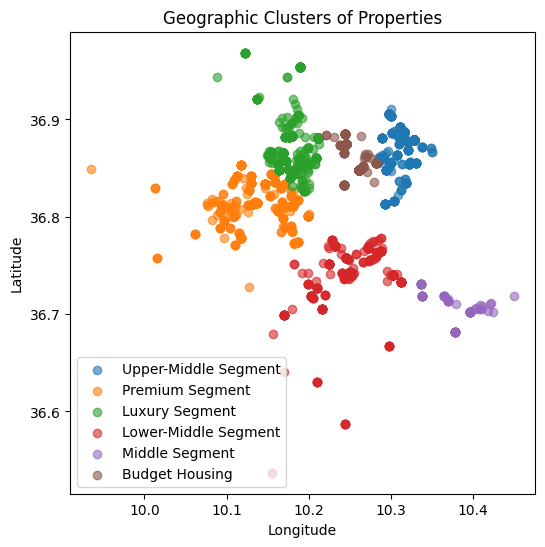

In [122]:
plt.figure(figsize=(6,6))

for cluster in eda_df["geo_cluster"].unique():
    subset = eda_df[eda_df["geo_cluster"] == cluster]
    plt.scatter(
        subset["lon"],
        subset["lat"],
        label=cluster_names[cluster],
        alpha=0.6
    )

plt.legend()
plt.title("Geographic Clusters of Properties")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [123]:

# Center map on Tunis
map_center = [eda_df["lat"].mean(), eda_df["lon"].mean()]
m = folium.Map(location=map_center, zoom_start=11)

# Colors for clusters
colors = ["red", "blue", "green", "purple", "orange", "darkred"]

for _, row in eda_df.iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=3,
        color=colors[row["geo_cluster"]],
        fill=True,
        fill_opacity=0.7,
        popup=f"Price: {row['prix']:.0f} TND\nCluster: {cluster_names[row['geo_cluster']]}"
    ).add_to(m)




In [124]:
merged_df.to_csv("dataset.csv", index=False)

Cluster centers (price):
[ 3934090.81818182   300022.83431635  1973560.44776119 11766666.66666667
   678080.06153846  1196610.96166134]

Average price per cluster:
price_cluster
1       300,023
4       678,080
5     1,196,611
2     1,973,560
0     3,934,091
3    11,766,667
Name: prix, dtype: object


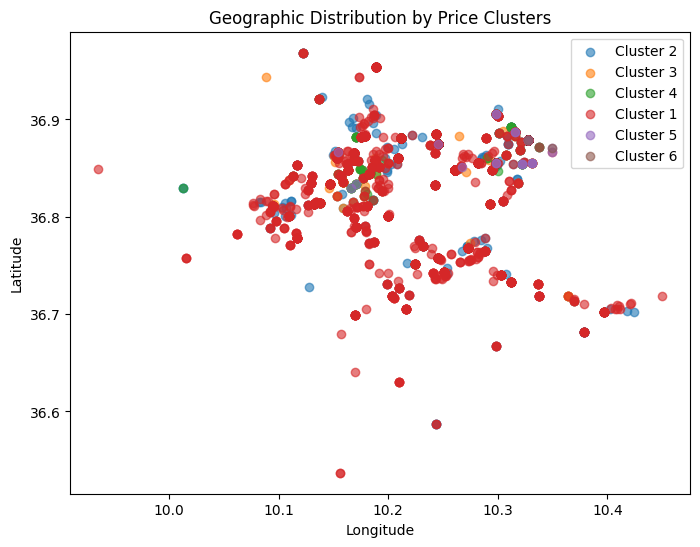

In [125]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import folium

# -----------------------------
# Cluster by price
# -----------------------------
price_data = merged_df[["prix"]].copy()  # Use only price

# Number of clusters (adjust as needed)
n_clusters = 6
kmeans_price = KMeans(n_clusters=n_clusters, random_state=42)

# Copy df
eda_df = merged_df.copy()

# Assign price clusters
eda_df["price_cluster"] = kmeans_price.fit_predict(price_data)

# Cluster centers (average price)
centers = kmeans_price.cluster_centers_
print("Cluster centers (price):")
print(centers.flatten())

# Mean price per cluster
cluster_price = eda_df.groupby("price_cluster")["prix"].mean().sort_values()
formatted_prices = cluster_price.apply(lambda x: f"{x:,.0f}")
print("\nAverage price per cluster:")
print(formatted_prices)

# -----------------------------
# Visualize price clusters geographically
# -----------------------------
# Optional: create readable cluster names sorted by price
cluster_order = eda_df.groupby("price_cluster")["prix"].mean().sort_values().index
cluster_names = {cluster: f"Cluster {i+1}" for i, cluster in enumerate(cluster_order)}

plt.figure(figsize=(8, 6))
for cluster in eda_df["price_cluster"].unique():
    subset = eda_df[eda_df["price_cluster"] == cluster]
    plt.scatter(
        subset["lon"],  # x-axis
        subset["lat"],  # y-axis
        label=cluster_names[cluster],
        alpha=0.6
    )

plt.legend()
plt.title("Geographic Distribution by Price Clusters")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# -----------------------------
# Optional: Folium map
# -----------------------------
map_center = [eda_df["lat"].mean(), eda_df["lon"].mean()]
m = folium.Map(location=map_center, zoom_start=11)

# Colors for clusters
colors = ["red", "blue", "green", "purple", "orange", "darkred"]

for _, row in eda_df.iterrows():
    cluster_idx = int(row["price_cluster"])  # <-- convert to int
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=3,
        color=colors[cluster_idx],
        fill=True,
        fill_opacity=0.7,
        popup=f"Price: {row['prix']:.0f} TND\nCluster: {cluster_names[cluster_idx]}"
    ).add_to(m)


# Display map
m



Average price per cluster (whole data):
cluster_all
1      446,300
2      655,147
0    1,258,983
Name: prix, dtype: object


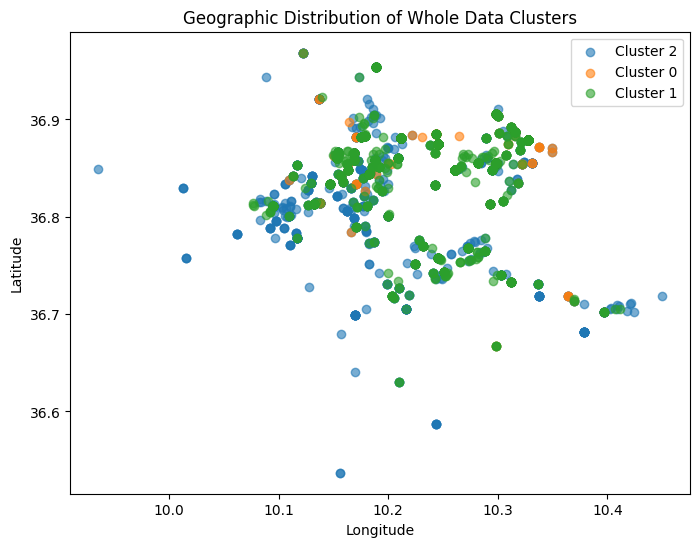

In [126]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# -----------------------------
# Select the numerical features for clustering
# -----------------------------
# Drop non-numeric columns like text, price_per_m2 if needed


X = merged_df.drop(columns=["prix","price_per_m2"]).copy()

# Optional: scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------------
# KMeans clustering
# -----------------------------
n_clusters = 3  # You can adjust
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
merged_df["cluster_all"] = kmeans.fit_predict(X_scaled)

# Cluster centers (scaled)
centers_scaled = kmeans.cluster_centers_

# -----------------------------
# Average price per cluster (original scale)
# -----------------------------
cluster_price = merged_df.groupby("cluster_all")["prix"].mean().sort_values()
formatted_prices = cluster_price.apply(lambda x: f"{x:,.0f}")
print("\nAverage price per cluster (whole data):")
print(formatted_prices)

# -----------------------------
# Visualize clusters on map using lat/lon
# -----------------------------
plt.figure(figsize=(8,6))

for cluster in merged_df["cluster_all"].unique():
    subset = merged_df[merged_df["cluster_all"] == cluster]
    plt.scatter(
        subset["lon"],
        subset["lat"],
        alpha=0.6,
        label=f"Cluster {cluster}"
    )

plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographic Distribution of Whole Data Clusters")
plt.show()


In [127]:
# Filter rows that belong to cluster 0
cluster_0 = merged_df[merged_df["cluster_all"] == 0]

# Show the prices
print(len(cluster_0))  # gives count, mean, std, min, max, quartiles
# Correct slicing with iloc
print(cluster_0.iloc[2:-1])

# Optionally, display the prices themselves
print(cluster_0["prix"].sort_values().to_list())


275
           prix  categorie  surface  nombre_des_chambres  \
39    1500000.0          0    673.0                  5.0   
47     985000.0          0    490.0                  4.0   
52     950000.0          0    380.0                  5.0   
54    2400000.0          0    450.0                  7.0   
55    1350000.0          0    300.0                  4.0   
...         ...        ...      ...                  ...   
3389   591000.0          1    145.0                  3.0   
3429   570000.0          1    110.0                  2.0   
3582   750000.0          0    247.0                  3.0   
3614  1200000.0          1    290.0                  5.0   
3667   790000.0          0    400.0                  3.0   

      nombre_des_salles_de_bains  haut_standing  terrasse  balcon  etage  \
39                           3.0              0         0       1    2.0   
47                           3.0              1         0       0    2.0   
52                           3.0              0

The MODEL

In [128]:
import numpy as np

# Label

y = np.log1p(merged_df["prix"].values).reshape(-1,1)

X = merged_df.drop(columns=["prix", "price_per_m2"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True
)


In [129]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test  = scaler_X.transform(X_test)


In [130]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [131]:
from sklearn.metrics import r2_score, mean_squared_error
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.2f}")


MSE: 0.14
R²: 0.72


In [132]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# Label
y = np.log1p(merged_df["prix"].values).reshape(-1, 1)

# Features
X = merged_df.drop(columns=["prix", "price_per_m2","cluster_all"])

# Number of folds
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)
r2_scores=[]
mse_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    # Split fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Pipeline = scaler + model (same as your original code)
    pipeline = Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("model", xgb.XGBRegressor(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        ))
    ])
    
    # Fit pipeline
    pipeline.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2=r2_score(y_test, y_pred)
    mse_scores.append(mse)
    r2_scores.append(r2)
    print(f"Fold {fold} MSE: {mse:.4f}")

# Mean MSE across all folds
mean_mse = np.mean(mse_scores)
mean_r2=np.mean(r2_scores)
print(f"\nMean MSE across {k} folds: {mean_mse:.4f}")
print(f"\nMean R2 across {k} folds: {mean_r2:.4f}")


Fold 1 MSE: 0.0659
Fold 2 MSE: 0.0724
Fold 3 MSE: 0.0770
Fold 4 MSE: 0.0580
Fold 5 MSE: 0.0579
Fold 6 MSE: 0.0516
Fold 7 MSE: 0.0703
Fold 8 MSE: 0.0651
Fold 9 MSE: 0.0545
Fold 10 MSE: 0.0605

Mean MSE across 10 folds: 0.0633

Mean R2 across 10 folds: 0.8673


In [133]:
import pandas as pd

feature_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": pipeline.named_steps["model"].feature_importances_
}).sort_values(by="importance", ascending=False)

feature_importance


feature  importance
1                      surface    0.340710
14                     piscine    0.107558
2          nombre_des_chambres    0.074760
3   nombre_des_salles_de_bains    0.070359
10                      jardin    0.069614
15                         lat    0.062388
12                 climatiseur    0.060931
16                         lon    0.051383
0                    categorie    0.028406
13           chauffage_central    0.022644
11             vue_panoramique    0.021155
4                haut_standing    0.020506
9                    ascenseur    0.019281
8                      parking    0.018673
7                        etage    0.015169
5                     terrasse    0.009463
6                       balcon    0.006999

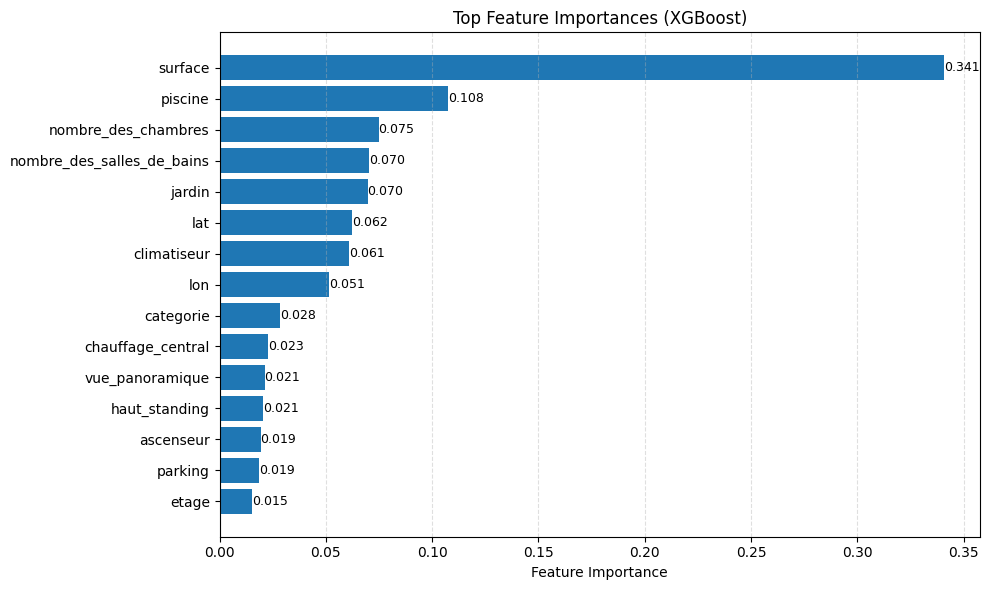

In [134]:
import matplotlib.pyplot as plt

# Keep only top N features for readability
TOP_N = 15
fi = feature_importance.head(TOP_N)


plt.figure(figsize=(10, 6))
bars = plt.barh(fi["feature"][::-1], fi["importance"][::-1])

plt.xlabel("Feature Importance")
plt.title("Top Feature Importances (XGBoost)")
plt.grid(axis="x", linestyle="--", alpha=0.4)

for bar in bars:
    width = bar.get_width()
    plt.text(
        width,
        bar.get_y() + bar.get_height() / 2,
        f"{width:.3f}",
        va="center",
        ha="left",
        fontsize=9
    )

plt.tight_layout()
plt.show()


In [135]:
import joblib
from pathlib import Path

# Save pipeline
Path("model").mkdir(exist_ok=True)  # create folder if not exists
pipeline_file = "model/xgb_pipeline.pkl"
joblib.dump(pipeline, pipeline_file)
print(f"✅ Pipeline saved to {pipeline_file}")


✅ Pipeline saved to model/xgb_pipeline.pkl


In [136]:
# Load saved pipeline
loaded_pipeline = joblib.load(pipeline_file)
print("✅ Loaded pipeline for inference")

# Example: predict on new data (here we use the same X for demonstration)
y_pred_loaded = loaded_pipeline.predict(X_test)
print("✅ Predictions on test data done")
mse = mean_squared_error(y_test, y_pred_loaded)
r2 = r2_score(y_test, y_pred_loaded)
print(r2)
# Optional: reverse log1p to get original price scale
y_pred = np.expm1(y_pred_loaded)
print(y_pred[:5])  # show first 5 predictions


✅ Loaded pipeline for inference
✅ Predictions on test data done
0.8782464723135718
[1399101.4  1036453.6  1462052.5   929545.06  365913.8 ]
